In [39]:
%load_ext autoreload
%autoreload 2
import os, random
import numpy as np
import dataset_loader
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import time

device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

def build_torch_inputs(data):
    x, y = data
    ret = list()
    
    for i in range(x.shape[0]):
        input_tensor = torch.from_numpy(x[i]).reshape(1, -1)
        output_value = int(y[i])
        
        ret.append({
            "input_tensor": input_tensor,
            "output_value": output_value
        })
        
    return ret
        
train_data = build_torch_inputs(train_data)
dev_data = build_torch_inputs(dev_data)
test_data = build_torch_inputs(test_data)

In [41]:
# just a helper function
def build_batch(data):
    batch_inputs = torch.cat(
        [data["input_tensor"] for data in data],
        dim=0
    )

    labels = torch.LongTensor([data["output_value"] for data in data ])
    
    return batch_inputs, labels

In [42]:
# A network network is a class extending nn.Module
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden_proj = nn.Linear(input_dim, hidden_dim)
        self.output_proj = nn.Linear(hidden_dim, output_dim)
                
        with torch.no_grad():
            torch.nn.init.kaiming_uniform_(self.hidden_proj.weight.data)
            torch.nn.init.kaiming_uniform_(self.output_proj.weight.data)
            
            self.hidden_proj.bias.zero_()
            self.output_proj.bias.zero_()
        
    def forward(self, inputs):
        z = self.hidden_proj(inputs)
        z = torch.relu(z)
        return self.output_proj(z)

In [43]:
logits = torch.tensor([
    [432699.1875, 300807.1250, 389614.0312, 396122.1562, 410441.5625, 280411.0000, 426984.9375, 382853.3750, 427784.6875, 344430.3125],
    [174335.7188, 121234.3125, 156996.5781, 159618.2188, 165396.4844, 112990.3438, 172047.2812, 154292.2500, 172379.9531, 138800.5625],
    [284093.5625, 197565.0625, 255842.6250, 260127.5938, 269514.0312, 184131.4375, 280361.3125, 251412.3125, 280909.1250, 226173.8438],
    [219632.6406, 152675.4844, 197763.0312, 201069.3125, 208362.4062, 142334.1094, 216726.0625, 194384.1094, 217143.9688, 174859.1250],
    ])

labels = torch.tensor([8, 7, 3, 7])

perfect_logits = torch.tensor([
    [0, 0, 0, 0, 0, 0, 0, 0, 427784.6875, 0],
    [0, 0, 0, 0, 0, 0, 0, 154292.2500, 0, 0],
    [0, 0, 0, 260127.5938, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 194384.1094, 0, 0]
    ])

def nll_loss_custom(logits, labels):
    # Calculate the range of indices for the batch elements  
    batch_indices = range(logits.shape[0])
    # Select the logit for the correct label of each batch element  
    selected_logits = logits[batch_indices, labels]
    # Use the logsumexp function to calculate the log of the sum of exponentials of the logits  
    log_sum_exp = torch.logsumexp(logits, dim=1)
    # Calculate the mean negative log likelihood loss for the batch  
    loss = - selected_logits + log_sum_exp
    return loss.mean()


print(f"F.nll_loss : {F.nll_loss(F.log_softmax(logits, dim=1), labels,reduction='mean')}")
# print(f'nll_loss_custom : {nll_loss_custom(F.log_softmax(logits, dim=1), labels)}')
print(f'nll_loss_custom : {nll_loss_custom(logits, labels)}')
print(f'nll_loss_custom perfect pred : {nll_loss_custom(perfect_logits, labels)}')

# assert F.nll_loss(logits, labels) == nll_loss_custom(logits, labels)



F.nll_loss : 18543.1171875
nll_loss_custom : 18543.1171875
nll_loss_custom perfect pred : 0.0


In [6]:
# Example of a training loop! :)

# hyper-parameters
n_epochs = 10
batch_size = 5

# Build the network
network = MLPClassifier(784, 200, 10)
network.to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=1e-3, momentum=0.9)

start = time.time()
for epoch in range(n_epochs):
    print("%i / %i" % (epoch+1, n_epochs))
    
    random.shuffle(train_data)
    
    network.train()
    
    for first_element in range(0, len(train_data), batch_size):
        optimizer.zero_grad()
        
        batch_input, labels = build_batch(train_data[first_element:first_element + batch_size])
        batch_input = batch_input.to(device)
        labels = labels.to(device)
        logits = network(batch_input)          
        # Modified loss to take into account partial labeling
        loss = nll_loss_custom(logits, labels)
        
        loss.backward()

        optimizer.step()
        
    n_correct = 0
    with torch.no_grad(): 
        network.eval()
        
        for first_element in range(0, len(dev_data), batch_size):
            optimizer.zero_grad()

            batch_input, labels = build_batch(dev_data[first_element:first_element + batch_size])
            batch_input = batch_input.to(device)
            labels = labels.to(device)
            logits = network(batch_input)
            
            prediction = logits.argmax(dim=1)
            
            n_correct += (prediction == labels).sum().item()

    print("Dev acc: %.2f" % (100 * n_correct / len(dev_data)))
    
print(time.strftime("%H:%M:%S", time.gmtime(time.time()-start)))

1 / 10
Dev acc: 93.82
2 / 10
Dev acc: 95.45
3 / 10
Dev acc: 96.33
4 / 10
Dev acc: 96.81
5 / 10
Dev acc: 97.13
6 / 10
Dev acc: 97.21
7 / 10
Dev acc: 97.47
8 / 10
Dev acc: 97.48
9 / 10
Dev acc: 97.65
10 / 10
Dev acc: 97.70


# Partial labeling

In [44]:
print('Before adding noise : ', [data['output_value'] for data in train_data][:50])

# Add noise in data, meaning instead of one label for 'output_value', we will have 3 labels in 30% of the cases
def add_noise(data):
    for i in range(len(data)):
        if(random.random() < 0.3):
            range_sample = list(range(10))
            range_sample.remove(data[i]["output_value"])
            new_samples = random.sample(range_sample, 2)
            new_label = [data[i]["output_value"], new_samples[0], new_samples[1]]
            random.shuffle(new_label)
            data[i]["output_value"] = new_label
        else:
            label = data[i]['output_value']
            data[i]['output_value'] = [label]
    return data

train_data = add_noise(train_data)

print('After adding noise : ', [data['output_value'] for data in train_data][:50])


Before adding noise :  [0, 2, 0, 3, 6, 4, 4, 3, 1, 9, 0, 2, 9, 6, 4, 4, 1, 8, 0, 2, 3, 2, 8, 0, 0, 7, 6, 7, 4, 2, 0, 7, 0, 0, 6, 8, 5, 3, 4, 4, 8, 2, 1, 8, 0, 0, 5, 9, 0, 9]
After adding noise :  [[0], [2], [0, 8, 9], [0, 9, 3], [6], [4], [3, 4, 0], [3], [4, 1, 3], [9], [8, 0, 9], [0, 2, 5], [8, 9, 1], [6, 1, 2], [4], [4], [1], [8], [0], [2], [3], [2], [8], [0], [0], [0, 5, 7], [6, 8, 4], [7], [4], [2], [0, 2, 9], [7], [0], [1, 0, 4], [6], [8, 1, 6], [5], [3], [4], [3, 9, 4], [8], [2], [7, 3, 1], [8], [0], [0], [5], [9], [0, 9, 5], [9]]


In [45]:
logits = torch.tensor([
    [432699.1875, 300807.1250, 389614.0312, 396122.1562, 410441.5625, 280411.0000, 426984.9375, 382853.3750, 427784.6875, 344430.3125],
    [174335.7188, 121234.3125, 156996.5781, 159618.2188, 165396.4844, 112990.3438, 172047.2812, 154292.2500, 172379.9531, 138800.5625],
    [284093.5625, 197565.0625, 255842.6250, 260127.5938, 269514.0312, 184131.4375, 280361.3125, 251412.3125, 280909.1250, 226173.8438],
    [219632.6406, 152675.4844, 197763.0312, 201069.3125, 208362.4062, 142334.1094, 216726.0625, 194384.1094, 217143.9688, 174859.1250],
    ])



perfect_logits = torch.tensor([
    [0, 0, 0, 0, 0, 0, 0, 0, 427784.6875, 0],
    [0, 0, 156996.5781, 0, 0, 0, 0, 154292.2500, 0, 0],
    [284093.5625, 0, 0, 260127.5938, 0, 0, 0, 251412.3125, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 194384.1094, 0, 0]
    ])

# Define the number of classes  
num_classes = logits.shape[1]  

# Create a tensor of labels  
labels = [[8], [7, 2], [3, 8, 0], [7]]
# print(f'labels : {labels}')
tensor_labels = list()
for ls in labels:
    t = torch.zeros(num_classes, dtype=torch.long)
    t[ls] = 1
    tensor_labels.append(t)
tensor_labels = torch.stack(tensor_labels)
print(f'labels one hot : {tensor_labels}')

def nll_loss_marginalized(logits, labels):
    mask = torch.zeros_like(logits)
    mask[labels==0]=float("-inf")
    # Select the logit for the correct label/set of labels of each batch element
    selected_logits = logits + mask
    log_sum_exp_selected_logits = torch.logsumexp(selected_logits, dim=1)
    # Use the logsumexp function to calculate the log of the sum of exponentials of the logits  
    log_sum_exp = torch.logsumexp(logits, dim=1)
    # Calculate the mean negative log likelihood loss for the batch  
    loss = - log_sum_exp_selected_logits + log_sum_exp
    return loss.mean()

print(f'nll_loss_marginalized : {nll_loss_marginalized(logits, tensor_labels)}')
print(f'nll_loss_marginalized perfect prediction : {nll_loss_marginalized(perfect_logits, tensor_labels)}')


labels one hot : tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])
nll_loss_marginalized : 11875.54296875
nll_loss_marginalized perfect prediction : 0.0


In [46]:
def build_batch_noised(data, num_classes):
    batch_inputs = torch.cat(
        [data["input_tensor"] for data in data],
        dim=0
    )

    labels = [data["output_value"] for data in data]

    labels = [F.one_hot(torch.tensor(l), num_classes =num_classes) if isinstance(l,int) else sum(F.one_hot(torch.tensor(l), num_classes =num_classes)) for l in labels]
    labels = torch.stack(labels)
    
    return batch_inputs, labels
print('After adding noise : ', [data['output_value'] for data in train_data][:5])
print(build_batch_noised(train_data[:5], 10)[1])

After adding noise :  [[0], [2], [0, 8, 9], [0, 9, 3], [6]]
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])


1 / 10
Dev acc: 89.26
2 / 10
Dev acc: 90.82
3 / 10
Dev acc: 91.82
4 / 10
Dev acc: 92.51
5 / 10
Dev acc: 92.92
6 / 10
Dev acc: 93.30
7 / 10
Dev acc: 93.62
8 / 10
Dev acc: 93.96
9 / 10
Dev acc: 94.32
10 / 10
Dev acc: 94.53
00:06:49


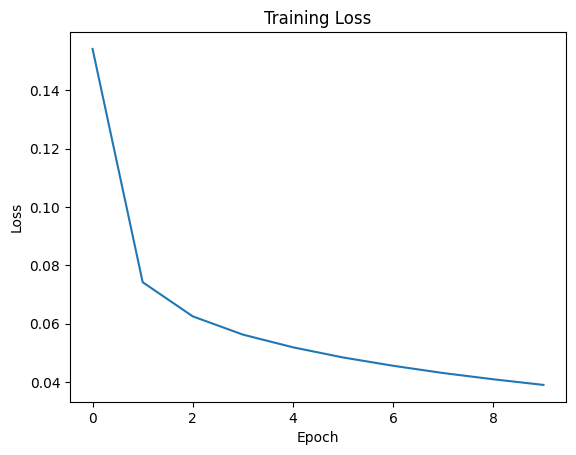

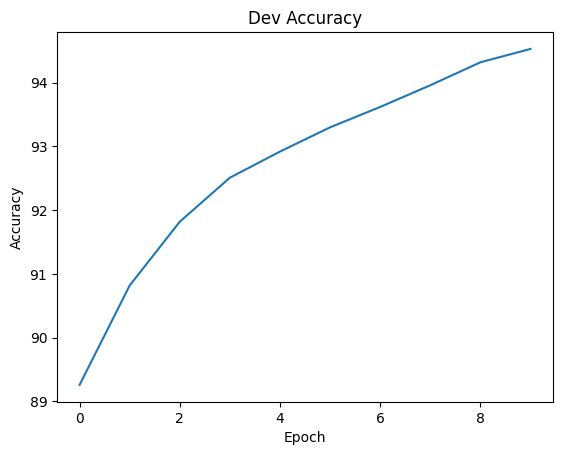

In [48]:
import matplotlib.pyplot as plt  
  
def count_correct_preds(predictions_one_hot, labels):  
    num_correct = 0    
    for i in range(predictions_one_hot.size(0)):    
        pred = torch.argmax(predictions_one_hot[i])    
        label = torch.nonzero(labels[i]).flatten()    
        if pred in label:    
            num_correct += 1    
    return num_correct    
  
# hyper-parameters  
batch_size = 5
n_epochs = 10
# Build the network  
network = MLPClassifier(784, 200, 10)  
network.to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=1e-3, momentum=0.1)  
  
train_losses = []  
dev_accs = []  
  
start = time.time()
for epoch in range(n_epochs):  
    print("%i / %i" % (epoch+1, n_epochs))  
      
    random.shuffle(train_data)  
      
    network.train()  
    train_loss = 0
      
    for first_element in range(0, len(train_data), batch_size):  
        optimizer.zero_grad()  
          
        batch_input, labels = build_batch_noised(train_data[first_element:first_element + batch_size], 10)  
        batch_input = batch_input.to(device)
        labels = labels.to(device)
        logits = network(batch_input)  
        # Modified loss to take into account partial labeling  
        loss = nll_loss_marginalized(logits, labels)  
        loss.backward()  
  
        optimizer.step()  
          
        train_loss += loss.item()  
          
    train_losses.append(train_loss / len(train_data))  
    n_correct = 0  
    with torch.no_grad():   
        network.eval()  
          
        for first_element in range(0, len(dev_data), batch_size):  
            batch_input, labels = build_batch_noised(dev_data[first_element:first_element + batch_size], 10)  
            batch_input = batch_input.to(device)
            labels = labels.to(device)
            logits = network(batch_input)  
              
            prediction = logits.argmax(dim=1)  
              
            n_correct += count_correct_preds(F.one_hot(prediction, num_classes=10), labels)  
  
    dev_acc = 100 * n_correct / len(dev_data)  
    dev_accs.append(dev_acc)  
    print("Dev acc: %.2f" % dev_acc)

print(time.strftime("%H:%M:%S", time.gmtime(time.time()-start)))

# Plot the training loss and dev accuracy  
plt.plot(train_losses)  
plt.title('Training Loss')  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.show()  
  
plt.plot(dev_accs)  
plt.title('Dev Accuracy')  
plt.xlabel('Epoch')  
plt.ylabel('Accuracy')  
plt.show()  



# Partial Labeling with ratio constraints

In [49]:
def solve_via_bregman(W, mask, ratio, max_iter=10, eps=1):
    """
    1. Select elements of matrix to modify
    2. Apply first projection on these elements (condition 1, \sum mu_i =1)
    3. Apply second projection on these elements (condition 2, \sum mu_i on  =1)
    """
    # Put everything on same device
    W = W.to(device)
    mask = mask.to(device)
    ratio = ratio.to(device)
    
    not_mask = mask!=1
    W = - W.clone() / eps
    W[not_mask]=float("-inf")
    for _ in range(max_iter):
        # Project on first constraint set (sum of columns = 1)
        W = torch.log_softmax(W, dim=1)
        # Project on second constraint set (sum of lines = b on constrained elements)
        W = torch.log_softmax(W, dim=0) + torch.log(ratio)
    return W.exp()

In [102]:
def compute_logsumexp_z(W, mask, ratio):
    W = W.to(device)
    ratio = ratio.to(device)
    mask = mask.to(device)
    
    ratio = ratio * W.shape[0]
    
    with torch.no_grad():
        P = solve_via_bregman(W, mask, ratio)
        
    return (P*W).sum(dim=1) - torch.nan_to_num(P*P.log()).sum(dim=1)

In [103]:
def nll_loss_eer(preds, labels, ratio):
    # Perform Bregman Projections to inlcude Expected Entity Ratio on Z
    log_sum_exp_Z = compute_logsumexp_z(preds, labels, ratio)
    
    # Calculate logsumexp on Y
    log_sum_exp_Y = torch.logsumexp(preds, dim=1)
    
    loss = - log_sum_exp_Z.mean() + log_sum_exp_Y.mean()
    return loss

1 / 10
tensor(1.9761, device='mps:0', grad_fn=<AddBackward0>)
Dev acc: 20.38
2 / 10
tensor(1.9675, device='mps:0', grad_fn=<AddBackward0>)
Dev acc: 35.17
3 / 10
tensor(1.9479, device='mps:0', grad_fn=<AddBackward0>)
Dev acc: 44.19
4 / 10
tensor(1.9124, device='mps:0', grad_fn=<AddBackward0>)
Dev acc: 50.94
5 / 10
tensor(1.8645, device='mps:0', grad_fn=<AddBackward0>)
Dev acc: 58.96
6 / 10
tensor(1.8050, device='mps:0', grad_fn=<AddBackward0>)
Dev acc: 63.33
7 / 10
tensor(1.7441, device='mps:0', grad_fn=<AddBackward0>)
Dev acc: 64.31
8 / 10
tensor(1.7018, device='mps:0', grad_fn=<AddBackward0>)
Dev acc: 64.99
9 / 10
tensor(1.6786, device='mps:0', grad_fn=<AddBackward0>)
Dev acc: 70.10
10 / 10
tensor(1.6480, device='mps:0', grad_fn=<AddBackward0>)
Dev acc: 69.02
00:01:11


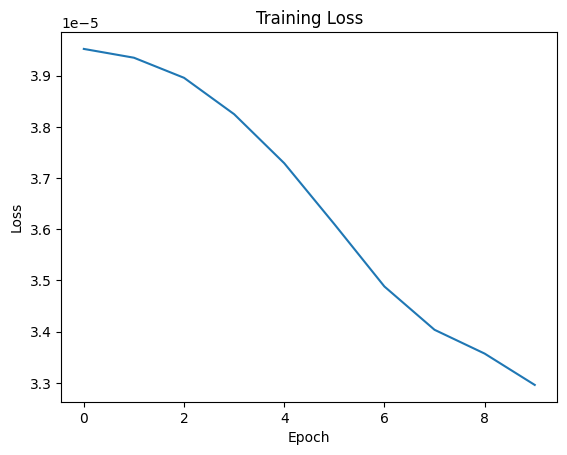

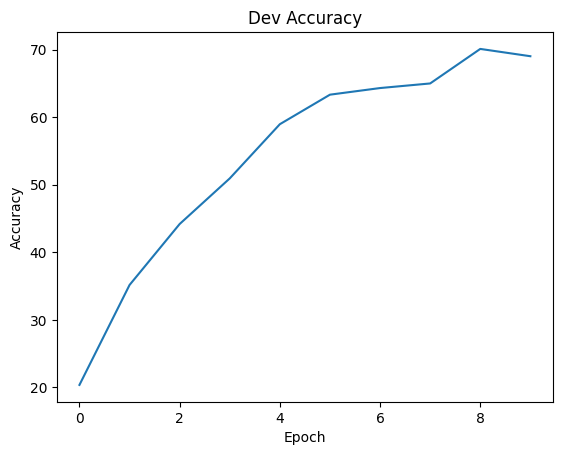

In [52]:
import matplotlib.pyplot as plt  
  
def count_correct_preds(predictions_one_hot, labels):  
    num_correct = 0    
    for i in range(predictions_one_hot.size(0)):    
        pred = torch.argmax(predictions_one_hot[i])    
        label = torch.nonzero(labels[i]).flatten()    
        if pred in label:    
            num_correct += 1    
    return num_correct    
  
# hyper-parameters  
batch_size = int(len(train_data))
n_epochs = 10
ratio = torch.tensor([0.1 for _ in range(10)])

# Build the network  
network = MLPClassifier(784, 200, 10)  
network.to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=1, momentum=0.9)  
  
train_losses = []  
dev_accs = []  

start = time.time()

for epoch in range(n_epochs):  
    print("%i / %i" % (epoch+1, n_epochs))  
      
    random.shuffle(train_data)  
      
    network.train()  
    train_loss = 0
      
    for first_element in range(0, len(train_data), batch_size):  
        optimizer.zero_grad()  
          
        batch_input, labels = build_batch_noised(train_data[first_element:first_element + batch_size], 10)
        batch_input = batch_input.to(device)
        labels = labels.to(device)
        logits = network(batch_input)

        # Modified loss to take into account partial labeling
        loss = nll_loss_eer(F.softmax(logits, dim=1), labels, ratio)  
        
        print(loss)
        
        loss.backward(retain_graph=True)  
        
        optimizer.step()  
        
        train_loss += loss.item()  
          
    train_losses.append(train_loss /len(train_data))  

    n_correct = 0  
    with torch.no_grad():   
        network.eval()

        for first_element in range(0, len(dev_data), batch_size):  
            batch_input, labels = build_batch_noised(dev_data[first_element:first_element + batch_size], 10)  
            batch_input = batch_input.to(device)
            labels = labels.to(device)
            logits = network(batch_input)  
            prediction = logits.argmax(dim=1)  
              
            n_correct += count_correct_preds(F.one_hot(prediction, num_classes=10), labels)  
  
    dev_acc = 100 * n_correct / len(dev_data)  
    dev_accs.append(dev_acc)  
    print("Dev acc: %.2f" % dev_acc)
      
print(time.strftime("%H:%M:%S", time.gmtime(time.time()-start)))

# Plot the training loss and dev accuracy  
plt.plot(train_losses)  
plt.title('Training Loss')  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.show()  
  
plt.plot(dev_accs)  
plt.title('Dev Accuracy')  
plt.xlabel('Epoch')  
plt.ylabel('Accuracy')  
plt.show() 

In [53]:
X_train = [data['input_tensor'] for data in train_data]
# ---------------------------------------------------------------
Y_train = []
for data in train_data:
    if type(data['output_value'])==list:
        Y_train.append(data['output_value'])
    else:
        Y_train.append([data['output_value']])
# ---------------------------------------------------------------
Y_dev = []
for data in dev_data:
    if type(data['output_value'])==list:
        Y_dev.append(data['output_value'])
    else:
        Y_dev.append([data['output_value']])
# ---------------------------------------------------------------
label_list=np.unique([item for l in Y_train  for item in l])

In [57]:
pad_token = -100
# Pad Y from data to have the same length
max_len = max([len(y) for y in Y_train])
Y_train = [y + [pad_token]*(max_len-len(y)) for y in Y_train]
print(Y_train[:10])
random.shuffle(Y_train)
print(Y_train[:10])


[[0, -100, -100], [7, -100, -100], [5, -100, -100], [0, -100, -100], [7, -100, -100], [1, 3, 6], [8, -100, -100], [1, -100, -100], [6, -100, -100], [0, -100, -100]]
[[0, -100, -100], [1, -100, -100], [0, 4, 9], [2, 6, 9], [8, -100, -100], [2, -100, -100], [6, -100, -100], [5, -100, -100], [2, -100, -100], [2, -100, -100]]


In [99]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np


class MNISTDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels.copy()
        # Convert labels to one hot encoding by ignoring the padding token
        for i in range(len(self.labels)):
            self.labels[i] = [item for item in self.labels[i] if item != -100]
            self.labels[i] = F.one_hot(torch.tensor(self.labels[i]), num_classes=10).sum(dim=0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return self.data[idx], self.labels[idx]

                
class CustomSampler():
    def __init__(self, data, ratio, batch_size):
        self.ratio = ratio*batch_size
        self.label_list = range(10)
        self.indices_by_class = {label:[] for label in self.label_list if label != -100}
        self.num_samples = len(data)
        self.data = data
        for i, y in enumerate(data):
            for label in y :
                if label != -100:
                    self.indices_by_class[label].append(i)
        
        self.batch_size = batch_size
    
    def __iter__(self):
        indices = 0
        indices_by_class_copy = {k: v.copy() for k, v in self.indices_by_class.items()} # Create a copy of the dictionary
        for k, v in indices_by_class_copy.items():
            random.shuffle(v)
        while indices < self.num_samples:
            batch = []
            # Modify the while test. It should not be on len(batch) but on the ratio of each class in the batch
            while len(batch) < self.batch_size:
                loop_ratio = self.ratio.clone()
                norm_ratio = loop_ratio/loop_ratio.sum()
                # print(loop_ratio)
                # print(norm_ratio.sum())
                # Select a class
                class_ = np.random.choice(range(10), p=norm_ratio)
                # If there are still samples available for the selected class
                if len(indices_by_class_copy[class_]) > 0:
                    chosen_idx = indices_by_class_copy[class_].pop()
                    # Pop an index from the list of indices for this class and add it to the batch
                    batch.append(chosen_idx)
                    # Update the ratio tensor by subtracting 1 from the count of the selected class
                    indices += 1
                    loop_ratio[class_] -= 1
                    # Remove the selected index from the list of indices of other classes (in case it is a partial label)
                    for label in self.data[chosen_idx]:
                        if label != -100 and label != class_:
                            indices_by_class_copy[label].remove(chosen_idx)
                            loop_ratio[label] -= 1
            yield from iter(batch)

    def __len__(self):
        return self.num_samples
    
def collate_fn(batch):
    inputs, labels = zip(*batch)
    return torch.cat(inputs, dim=0), torch.stack(labels)

# Usage
batch_size = 10000  # Replace with your actual batch size
ratio = ratio_train.clone()  # Replace with your actual ratio
sampler = CustomSampler(Y_train.copy(), ratio, batch_size)

dataloader = DataLoader(MNISTDataset([data['input_tensor'] for data in train_data], Y_train), batch_size=batch_size, sampler=sampler, collate_fn=collate_fn)

for batch in dataloader:    
    print(batch[0].shape, batch[1].shape)

# dev_sampler = CustomSampler(Y_dev.copy(), ratio, batch_size)
# dev_dataloader = DataLoader(MNISTDataset([data['input_tensor'] for data in dev_data], Y_dev), batch_size=10000, sampler=dev_sampler,  collate_fn=collate_fn)
# 
# for batch in dev_dataloader:    
#     print(batch[0].shape, batch[1].shape)

torch.Size([10000, 784]) torch.Size([10000, 10])
torch.Size([10000, 784]) torch.Size([10000, 10])
torch.Size([10000, 784]) torch.Size([10000, 10])
torch.Size([10000, 784]) torch.Size([10000, 10])
torch.Size([10000, 784]) torch.Size([10000, 10])


In [100]:
# Check ratio of labels
def check_ratio(data):
    labels = [data['output_value'] for data in data]
    labels = [l if isinstance(l, list) else [l] for l in labels]
    labels = [item for sublist in labels for item in sublist]
    label_list = np.unique(labels)
    ratio = [labels.count(label) for label in label_list]
    ratio = [r/len(labels) for r in ratio]
    return ratio

print(torch.tensor(check_ratio(train_data)))
print(check_ratio(dev_data))

tensor([0.1001, 0.1088, 0.0995, 0.1003, 0.0980, 0.0949, 0.0990, 0.1024, 0.0982,
        0.0988])
[0.0991, 0.1064, 0.099, 0.103, 0.0983, 0.0915, 0.0967, 0.109, 0.1009, 0.0961]


Start training
1 / 10
Evaluating...
Dev acc: 11.61
2 / 10
Evaluating...
Dev acc: 11.36
3 / 10
Evaluating...
Dev acc: 13.17
4 / 10
Evaluating...
Dev acc: 15.01
5 / 10
Evaluating...
Dev acc: 14.26
6 / 10
Evaluating...
Dev acc: 15.23
7 / 10
Evaluating...
Dev acc: 15.88
8 / 10
Evaluating...
Dev acc: 15.03
9 / 10
Evaluating...
Dev acc: 15.16
10 / 10
Evaluating...
Dev acc: 15.71
00:01:19


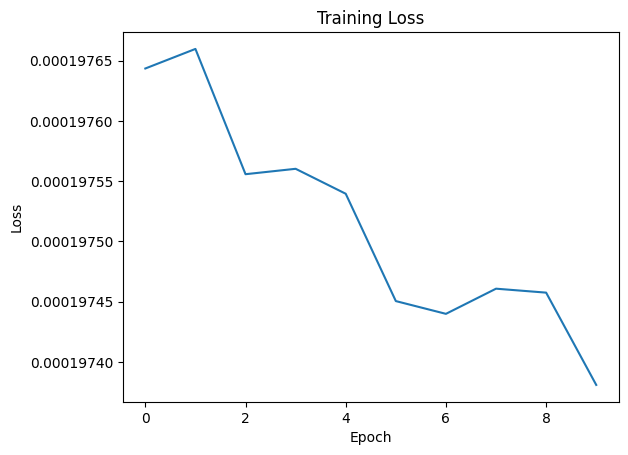

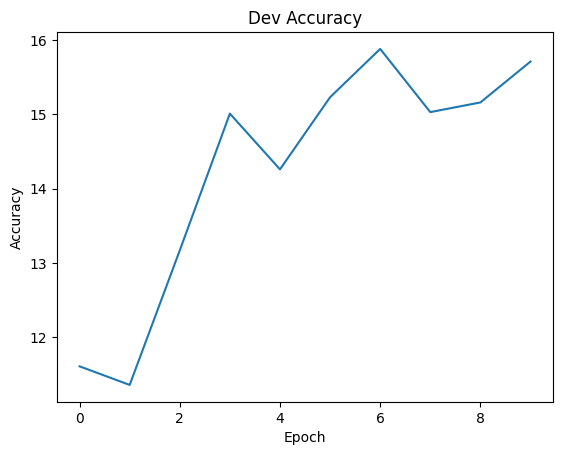

In [104]:
# hyper-parameters  
train_batch_size = 10000
dev_batch_size = 10000
n_epochs = 10
ratio_train = torch.tensor(check_ratio(train_data))
ratio_dev = torch.tensor(check_ratio(dev_data))

# DataLoader & Sampler
train_sampler = CustomSampler(Y_train.copy(), ratio_train, batch_size)
dev_sampler = CustomSampler(Y_dev.copy(), ratio_dev, dev_batch_size)

train_dataloader = DataLoader(MNISTDataset([data['input_tensor'] for data in train_data], Y_train), batch_size=train_batch_size, sampler=train_sampler, collate_fn=collate_fn)
dev_dataloader = DataLoader(MNISTDataset([data['input_tensor'] for data in dev_data], Y_dev), batch_size=dev_batch_size, sampler=dev_sampler,  collate_fn=collate_fn)

# Build the network  
network = MLPClassifier(784, 200, 10)  
network.to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=1, momentum=0.9)  
  
train_losses = []  
dev_accs = []  

start = time.time()

print('Start training')
for epoch in range(n_epochs):
    print("%i / %i" % (epoch+1, n_epochs))  
          
    network.train()  
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()  
          
        batch_input, labels = batch
        batch_input = batch_input.to(device)
        labels = labels.to(device)
        logits = network(batch_input)
        
        # Modified loss to take into account partial labeling
        loss = nll_loss_eer(F.softmax(logits, dim=1), labels, ratio)  

        loss.backward()  

        optimizer.step()  
        
        train_loss += loss.item()  
          
    train_losses.append(train_loss /len(train_data))  

    n_correct = 0  
    with torch.no_grad():   
        network.eval()
        print('Evaluating...')
        for batch in dev_dataloader:
            batch_input, labels = batch
            batch_input = batch_input.to(device)
            labels = labels.to(device)
            logits = network(batch_input)
              
            prediction = logits.argmax(dim=1)  
              
            n_correct += count_correct_preds(F.one_hot(prediction, num_classes=10), labels)  
  
    dev_acc = 100 * n_correct / len(dev_data)  
    dev_accs.append(dev_acc)  
    print("Dev acc: %.2f" % dev_acc)
      
print(time.strftime("%H:%M:%S", time.gmtime(time.time()-start)))

# Plot the training loss and dev accuracy  
plt.plot(train_losses)  
plt.title('Training Loss')  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.show()  
  
plt.plot(dev_accs)  
plt.title('Dev Accuracy')  
plt.xlabel('Epoch')  
plt.ylabel('Accuracy')  
plt.show() 